<a href="https://colab.research.google.com/github/DoggoWoofWoof/Implementation-of-GANS/blob/main/Sketch2Face%20Implementations/Malikanhar_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Git
!apt-get install -y git

# Clone the repository with sparse checkout enabled
!git clone --depth 1 --filter=blob:none --sparse https://github.com/Malikanhar/Face-Sketch-to-Image-Generation-using-GAN.git

# Navigate to the repository directory and checkout the specific folder
%cd Face-Sketch-to-Image-Generation-using-GAN
!git sparse-checkout init --cone
!git sparse-checkout set Dataset/CUHK

# Move the CUHK folder to the parent directory
!mv Dataset/CUHK ../CUHK

# Navigate back to the parent directory
%cd ..

# Remove the cloned repository
!rm -rf Face-Sketch-to-Image-Generation-using-GAN

# Verify the contents of the CUHK folder
!ls CUHK


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'Face-Sketch-to-Image-Generation-using-GAN'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 0), reused 15 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 20.54 KiB | 20.54 MiB/s, done.
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 1), reused 7 (delta 1), pack-reused 0
Receiving objects: 100% (8/8), 298.82 KiB | 5.75 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/Face-Sketch-to-Image-Generation-using-GAN
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100%

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import numpy as np
import glob
from PIL import Image

In [ ]:
def random_shearing(img, num, border):
    rows = img.shape[0]
    cols = img.shape[1]
    if num == 0:
        pts1 = np.float32([[5,5],[20,5],[2,20]])
        pts2 = np.float32([[10,10],[20,5],[5,25]])
    elif num == 1:
        pts1 = np.float32([[5,5],[15,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 2:
        pts1 = np.float32([[5,5],[15,5],[5,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 3:
        pts1 = np.float32([[5,5],[10,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 4:
        pts1 = np.float32([[5,5],[10,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,30]])
    else:
        pts1 = np.float32([[5,5],[10,5],[10,20]])
        pts2 = np.float32([[5,10],[10,10],[5,30]])
    M = cv2.getAffineTransform(pts1,pts2)
    return cv2.warpAffine(img, M, (cols,rows), borderValue=border)

def random_rotation(img, degree, border):
    rows = img.shape[0]
    cols = img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),degree,1)
    return cv2.warpAffine(img,M,(cols,rows), borderValue=border)

def transform_image(img, skt, ang_range, shear_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    # Border
    idx = 0
    border_img = tuple([int(img[idx][0][0]), int(img[idx][0][1]), int(img[idx][0][2])])
    border_skt = tuple([int(skt[0][0][0]), int(skt[0][0][1]), int(skt[0][0][2])])

    img = cv2.warpAffine(img,Rot_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,Trans_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,shear_M,(cols,rows), borderValue=border_img)

    skt = cv2.warpAffine(skt,Rot_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,Trans_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,shear_M,(cols,rows), borderValue=border_skt)

    return img, skt


In [ ]:
import os
import glob
import cv2

# Define the directories
sketch_dir = 'Dataset/Augmented sketch'
photo_dir = 'Dataset/Augmented photo'

# Create directories if they don't exist
os.makedirs(sketch_dir, exist_ok=True)
os.makedirs(photo_dir, exist_ok=True)

# Get the file names
p_filenames = sorted(glob.glob('CUHK/Training photo/*'))
s_filenames = sorted(glob.glob('CUHK/Training sketch/*'))

# Check if the lengths of the lists match
if len(p_filenames) != len(s_filenames):
    raise ValueError("The number of photo files and sketch files do not match.")

counter = 0
for i in range(len(p_filenames)):
    im = cv2.imread(p_filenames[i])
    sk = cv2.imread(s_filenames[i])

    if im is None or sk is None:
        print(f"Error reading file: {p_filenames[i]} or {s_filenames[i]}")
        continue

    for j in range(200):
        img, skt = transform_image(im, sk, 40, 10, 10)

        # Save the augmented images with zero-padded file names
        cv2.imwrite(os.path.join(photo_dir, f'{counter:05d}.jpg'), img)
        cv2.imwrite(os.path.join(sketch_dir, f'{counter:05d}.jpg'), skt)

        counter += 1

In [ ]:
from __future__ import print_function, division

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

# Helper Functions
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles, reverse=False)

def load_images(list_path, size=(256, 256)):
    img_list = list()
    for filename in list_path:
        pixels = load_img(filename, target_size=size)
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.makedirs(target_dir, exist_ok=True)  # Modified line
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    g_model.save(target_dir + 'g_model.h5')
    d_model.save(target_dir + 'd_model.h5')
    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

# Generator
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = BatchNormalization()(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = BatchNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d

    in_img = Input(shape=img_shape)

    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)

    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(in_img, out_img, name='generator')

# Discriminator
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = BatchNormalization()(d)
        return d

    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)

    merged = Concatenate()([in_src_img, in_target_img])

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)
    d4 = d_layer(d3, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([in_src_img, in_target_img], out, name='discriminator')

# GAN
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

# Train GAN model
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=32):
    n_patch = d_model.output_shape[1]

    blue_photo = data[0]
    blue_sketch = data[1]

    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')

        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):

            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))

            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            d_loss = 0.5 * np.add(d_loss1, d_loss2)

            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))

        summarize_performance(i, g_model, d_model, dataset, target_dir)

# Loss Function
def pixel_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def contextual_loss(y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(y_pred, [0,0,0,0], [16, 256, 256, 3]))
    b = tf.image.rgb_to_grayscale(tf.slice(y_true, [0,0,0,0], [16, 256, 256, 3]))

    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)

    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)

    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))

    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss(y_true, y_pred):
    px_loss = pixel_loss(y_true, y_pred)
    ctx_loss = contextual_loss(y_true, y_pred)
    return (0.2 * px_loss) + (0.8 * ctx_loss)

# Load Dataset
b_photo_path = 'Dataset/Augmented photo/'
b_sketch_path = 'Dataset/Augmented sketch/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

# Define GAN Model
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

opt = Adam(learning_rate=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

# Start Training
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], 'Models/Pixel[02]_Context[08]/', n_epochs=100, n_batch=32)

 ========== Epoch 1 ========== 
1/1 [==============================] - 0s 285ms/step
Batch : 1, D Loss : 0.826 | G Loss : 46.328
1/1 [==============================] - 0s 40ms/step
Batch : 2, D Loss : 0.807 | G Loss : 29.573
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 0.821 | G Loss : 22.102
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 0.811 | G Loss : 20.218
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 0.795 | G Loss : 17.970
1/1 [==============================] - 0s 32ms/step
Batch : 6, D Loss : 0.820 | G Loss : 16.708
1/1 [==============================] - 0s 41ms/step
Batch : 7, D Loss : 0.805 | G Loss : 15.736
1/1 [==============================] - 0s 30ms/step
Batch : 8, D Loss : 0.793 | G Loss : 14.143
1/1 [==============================] - 0s 31ms/step
Batch : 9, D Loss : 0.812 | G Loss : 13.871
1/1 [==============================] - 0s 31ms/step
Batch : 10, D Loss : 0.805 | G Loss : 14.338
1/1 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_000001.png and g_model & d_model
 ========== Epoch 2 ========== 
1/1 [==============================] - 0s 48ms/step
Batch : 1, D Loss : 0.828 | G Loss : 6.645
1/1 [==============================] - 0s 30ms/step
Batch : 2, D Loss : 0.797 | G Loss : 6.365
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 0.781 | G Loss : 5.961
1/1 [==============================] - 0s 31ms/step
Batch : 4, D Loss : 0.824 | G Loss : 6.721
1/1 [==============================] - 0s 35ms/step
Batch : 5, D Loss : 0.834 | G Loss : 6.300
1/1 [==============================] - 0s 31ms/step
Batch : 6, D Loss : 0.855 | G Loss : 6.159
1/1 [==============================] - 0s 31ms/step
Batch : 7, D Loss : 0.793 | G Loss : 18.163
1/1 [==============================] - 0s 30ms/step
Batch : 8, D Loss : 0.805 | G Loss : 12.298
1/1 [==============================] - 0s 30ms/step
Batch : 9, D Loss : 0.777 | G Loss : 8.862
1/1 [==============================] - 0s 30ms/step
Batch : 10, D

>Saved: plot_000002.png and g_model & d_model
 ========== Epoch 3 ========== 
1/1 [==============================] - 0s 52ms/step
Batch : 1, D Loss : 0.805 | G Loss : 6.038
1/1 [==============================] - 0s 42ms/step


KeyboardInterrupt: 

1/1 [==============================] - 2s 2s/step


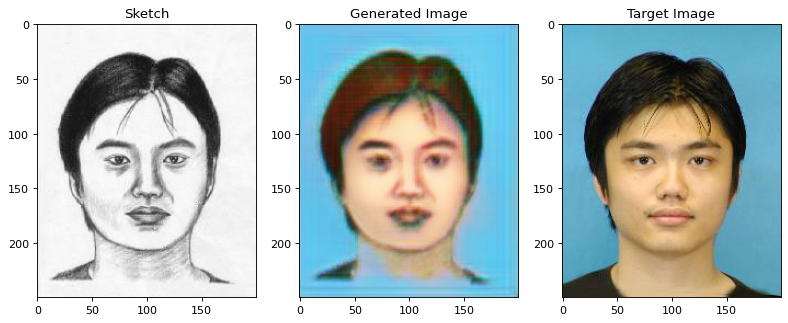

In [ ]:
from keras.layers import BatchNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load Model
g_model = load_model('Models/Pixel[02]_Context[08]/g_model.h5')

# load and resize the image
img = load_img('CUHK/Testing sketch/m1-001-01-sz1.jpg', target_size=(256, 256))
target = cv2.cvtColor(cv2.imread('CUHK/Testing photo/m1-001-01.jpg'), cv2.COLOR_BGR2RGB)

# convert to numpy array
img = img_to_array(img)
norm_img = (img.copy() - 127.5) / 127.5

g_img = g_model.predict(np.expand_dims(norm_img, 0))[0]
g_img = g_img * 127.5 + 127.5

img = cv2.resize(img, (200, 250))
g_img = cv2.resize(g_img, (200, 250))

f = plt.figure(num=None, figsize=(12, 6), dpi=80)
ax1 = f.add_subplot(1,3, 1)
plt.imshow(img.astype('uint8'))
ax2 = f.add_subplot(1,3, 2)
plt.imshow(g_img.astype('uint8'))
ax3 = f.add_subplot(1,3, 3)
plt.imshow(target.astype('uint8'))
ax1.set_title('Sketch')
ax2.set_title('Generated Image')
ax3.set_title('Target Image')

plt.show(block=True)

In [ ]:
from skimage.metrics import structural_similarity
import numpy as np
import natsort
import os
import cv2
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

def load_images(list_path):
    img_list = list()
    for filename in list_path:
        pixels = cv2.imread(filename)
        img_list.append(pixels)
    return np.asarray(img_list)
def compute_l2(imgs1, imgs2):
    l2_scores = []
    for i in range(len(imgs1)):
        score = (np.square(imgs1[i] - imgs2[i])).mean()
        l2_scores.append(score)
    return np.mean(l2_scores)

def compute_ssim(imgs1, imgs2):
    ssim_scores = []
    for i in range(len(imgs1)):
        grayA = cv2.cvtColor(imgs1[i], cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(imgs2[i], cv2.COLOR_BGR2GRAY)
        (score, diff) = structural_similarity(grayA, grayB, full=True)
        ssim_scores.append(score)
    return np.mean(score)

imgs1 = load_images(load_filename("CUHK/Testing photo/"))
imgs2 = load_images(load_filename("Generated Images/Generated_Pixel[02]_Context[08]/"))

l2 = compute_l2(imgs1, imgs2)
ssim = compute_ssim(imgs1, imgs2)

print("Pixel loss weight : 1 - Contextual loss weight : 0 => L2-norm: " + str(l2) + " :: SSIM: " + str(ssim))

Pixel loss weight : 1 - Contextual loss weight : 0 => L2-norm: 95.11671293333329 :: SSIM: 0.7345387763615782


1/1 [==============================] - 0s 264ms/step


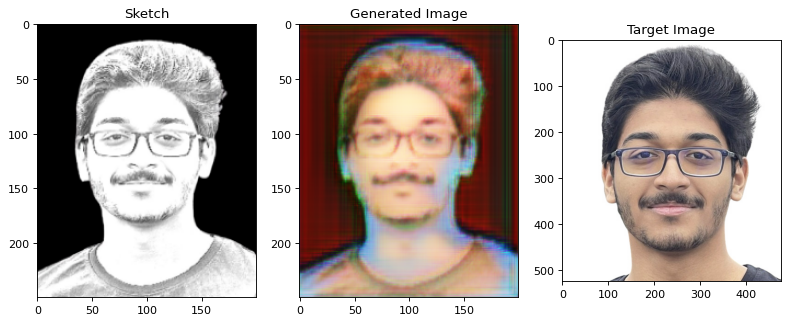

In [ ]:
from keras.layers import BatchNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load Model
g_model = load_model('Models/Pixel[02]_Context[08]/g_model.h5')

# load and resize the image
img = load_img('skerun2.jpeg', target_size=(256, 256))
target = cv2.cvtColor(cv2.imread('rerun.jpeg'), cv2.COLOR_BGR2RGB)

# convert to numpy array
img = img_to_array(img)
norm_img = (img.copy() - 127.5) / 127.5

g_img = g_model.predict(np.expand_dims(norm_img, 0))[0]
g_img = g_img * 127.5 + 127.5

img = cv2.resize(img, (200, 250))
g_img = cv2.resize(g_img, (200, 250))

f = plt.figure(num=None, figsize=(12, 6), dpi=80)
ax1 = f.add_subplot(1,3, 1)
plt.imshow(img.astype('uint8'))
ax2 = f.add_subplot(1,3, 2)
plt.imshow(g_img.astype('uint8'))
ax3 = f.add_subplot(1,3, 3)
plt.imshow(target.astype('uint8'))
ax1.set_title('Sketch')
ax2.set_title('Generated Image')
ax3.set_title('Target Image')

plt.show(block=True)